In [2]:
pip install -U imbalanced-learn


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler,  ClusterCentroids

from imblearn.metrics import classification_report_imbalanced, geometric_mean_score
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from imblearn.combine import SMOTETomek
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

Dans cet exercice nous utiliserons le jeu de données DCS de CBS

In [4]:
df = pd.read_csv('train_dcs.csv')
df.head()


,Unnamed: 0,sold_inc_cta_mt,total_amount_spa_failed_12M,curr_reindex_property_val_amt,nb_total_refunding_12M,crd_mt_cum_curr_reindex_property_val_amt,Overdue_3_plus_within_12_month
0,0,0,0,3,0,2,0
1,1,0,0,3,0,2,0
2,2,0,0,3,0,2,0
3,3,0,0,1,0,3,0
4,4,0,0,2,0,3,0


In [5]:
df=df.drop('Unnamed: 0', axis=1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24168 entries, 0 to 24167
Data columns (total 6 columns):
 #   Column                                    Non-Null Count  Dtype
---  ------                                    --------------  -----
 0   sold_inc_cta_mt                           24168 non-null  int64
 1   total_amount_spa_failed_12M               24168 non-null  int64
 2   curr_reindex_property_val_amt             24168 non-null  int64
 3   nb_total_refunding_12M                    24168 non-null  int64
 4   crd_mt_cum_curr_reindex_property_val_amt  24168 non-null  int64
 5   Overdue_3_plus_within_12_month            24168 non-null  int64
dtypes: int64(6)
memory usage: 1.1 MB


In [7]:
df.shape

(24168, 6)

In [8]:
for col in df.columns:
    print(f"**{col}** : \n", df[col].nunique(), df[col].unique())
 

**sold_inc_cta_mt** : 
 2 [0 1]
**total_amount_spa_failed_12M** : 
 2 [0 1]
**curr_reindex_property_val_amt** : 
 3 [3 1 2]
**nb_total_refunding_12M** : 
 2 [0 1]
**crd_mt_cum_curr_reindex_property_val_amt** : 
 3 [2 3 1]
**Overdue_3_plus_within_12_month** : 
 2 [0 1]


In [9]:
X=df.drop('Overdue_3_plus_within_12_month', axis=1)
y=df['Overdue_3_plus_within_12_month']

In [10]:
X.shape, y.shape

((24168, 5), (24168,))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [12]:
X_train=pd.get_dummies(X_train)
X_test=pd.get_dummies(X_test)

In [13]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [14]:
# Distribution de la target
y.value_counts(normalize=True)


Overdue_3_plus_within_12_month
0    0.985642
1    0.014358
Name: proportion, dtype: float64

Dans notre base clients, 1.4% des clients sont défaillants, ce qui signifie qu'un modèle naïf qui prédit que tous les clients ne sont pas défaillants, obtiendrait déjà un score de 98.6 % d'accuracy.

# 1 - 1er modèle : Régression Logistique

In [15]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [16]:
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.9840022065921942

Notre premier modèle, très simple, obtient 98.4% de bonnes prédictions sur le test.
Ce qui ne signifie pas que sur 100 clients défaillants, 98 seront identifiés comme tels par le modèle.

In [17]:
y_pred_lr = lr.predict(X_test)
cm = pd.crosstab(y_test, y_pred_lr, rownames=['Classe réelle'], colnames=['Classe prédite'])
cm


Classe prédite,0,1
Classe réelle,,
0,7127,6
1,110,8


La LR n'a détecté que 8 clients défaillants sur les 118 que contient l'échantillon de test

In [18]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7133
           1       0.57      0.07      0.12       118

    accuracy                           0.98      7251
   macro avg       0.78      0.53      0.56      7251
weighted avg       0.98      0.98      0.98      7251



- La précision mesure la proportion d'exemples positifs parmi les exemples que le modèle a prédits comme positifs.
La formule de la précision est donnée par : Precision=TP/TP+FP
La précision est importante lorsque les faux positifs sont coûteux. Par exemple, dans un test médical, où un faux positif peut entraîner des traitements inutiles.

- Le rappel mesure la proportion d'exemples positifs que le modèle a correctement prédits parmi tous les exemples positifs réels.
La formule du rappel est donnée par : Rappel= TP/TP+FN
Le rappel est important lorsque les faux négatifs sont coûteux. Par exemple, dans un test médical, où un faux négatif peut signifier qu'une maladie est manquée.


Dans notre cas, le rappel de la classe 1 est de 7% ce qui indique que le modèle n'a prédit que 7% des défaillants et 100% de ceux qui ne le sont pas

## AUC et courbe ROC

In [19]:
# Créer un tableau probs contenant les probabilités pour les individus de X_test d'appartenir à la classe 0 ou la classe 1.
probs_lr=lr.predict_proba(X_test)
probs_lr

array([[0.99361611, 0.00638389],
       [0.99361611, 0.00638389],
       [0.99217947, 0.00782053],
       ...,
       [0.99217947, 0.00782053],
       [0.99361611, 0.00638389],
       [0.99361611, 0.00638389]])

In [20]:
from sklearn.metrics import roc_curve
fpr_lr, tpr_lr, seuils=roc_curve(y_test, probs_lr[:,1], pos_label=1)

In [21]:
from sklearn.metrics import auc
roc_auc_lr=auc(fpr_lr, tpr_lr)
roc_auc_lr

0.7905984835343962

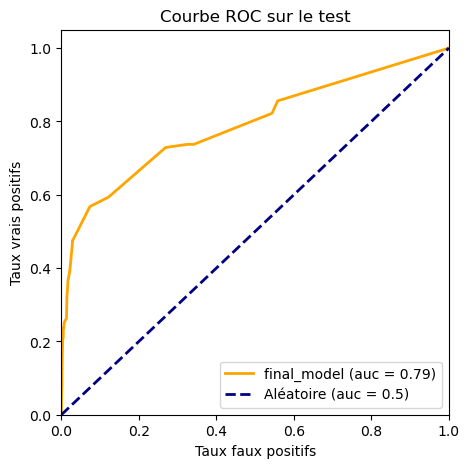

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))

plt.plot(fpr_lr, tpr_lr, color='orange', lw=2, label='final_model (auc = %0.2f)' % roc_auc_lr)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (auc = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')

plt.title('Courbe ROC sur le test')
plt.legend(loc="lower right")
plt.show();

Le modèle parvient à distinguer les classes dans 79% des cas 

La courbe ROC est utile pour évaluer la capacité du modèle à discriminer entre les classes, mais elle ne prend pas en compte la distribution des classes dans l'ensemble de données. 

Des méthodes dites de rééchantillonnage permettent de modifier les données avant d'entraîner le modèle dessus.
Ces méthodes se divisent en 2 groupes principaux : les méthodes de sur-échantillonnage (Oversampling) et de sous-échantillonnage (Undersampling).

# A - Méthodes Data Level

## A1 - L'oversampling

### A1.1 - RandomOverSampler

In [23]:

ros = RandomOverSampler()
X_ro, y_ro = ros.fit_resample(X_train, y_train)
print(y_ro.value_counts())


Overdue_3_plus_within_12_month
0    16688
1    16688
Name: count, dtype: int64


In [24]:
lr.fit(X_ro, y_ro)
y_pred_ros = lr.predict(X_test)
cm = pd.crosstab(y_test, y_pred_ros, rownames=['Classe réelle'], colnames=['Classe prédite'])
cm

Classe prédite,0,1
Classe réelle,,
0,6927,206
1,62,56


La LR a détecté 56 des 118 clients défaillants que contient l'échantillon de test. C'est mieux

In [25]:
print(classification_report(y_test, y_pred_ros))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      7133
           1       0.21      0.47      0.29       118

    accuracy                           0.96      7251
   macro avg       0.60      0.72      0.64      7251
weighted avg       0.98      0.96      0.97      7251



L'accuracy descend à 96% mais le modèle parvient maintenant à détecter 47% des défaillants

In [26]:
probs_ros=lr.predict_proba(X_test)
fpr_ros, tpr_ros, seuils=roc_curve(y_test, probs_ros[:,1], pos_label=1)
roc_auc_ros=auc(fpr_ros, tpr_ros)
roc_auc_ros

0.7906293736203418

### A1.2 - SMOTE

In [27]:
sm = SMOTE()
X_sm, y_sm = sm.fit_resample(X_train, y_train)
print(y_sm.value_counts())

Overdue_3_plus_within_12_month
0    16688
1    16688
Name: count, dtype: int64


In [28]:
lr.fit(X_sm, y_sm)
y_pred_smote = lr.predict(X_test)
cm = pd.crosstab(y_test, y_pred_smote, rownames=['Classe réelle'], colnames=['Classe prédite'])
cm


Classe prédite,0,1
Classe réelle,,
0,6927,206
1,62,56


In [29]:
print(classification_report(y_test, y_pred_smote))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      7133
           1       0.21      0.47      0.29       118

    accuracy                           0.96      7251
   macro avg       0.60      0.72      0.64      7251
weighted avg       0.98      0.96      0.97      7251



In [30]:
probs_smote=lr.predict_proba(X_test)
fpr_smote, tpr_smote, seuils=roc_curve(y_test, probs_smote[:,1], pos_label=1)
roc_auc_smote=auc(fpr_smote, tpr_smote)
roc_auc_smote

0.790561653047307

## A2 - L'Undersampling

### A2.1 - RandomUnderSampler

In [31]:
RUS=RandomUnderSampler()
X_ru, y_ru=RUS.fit_resample(X_train, y_train)
print(y_ru.value_counts())

Overdue_3_plus_within_12_month
0    229
1    229
Name: count, dtype: int64


In [32]:
lr.fit(X_ru, y_ru)
y_pred_rus = lr.predict(X_test)
cm = pd.crosstab(y_test, y_pred_rus, rownames=['Classe réelle'], colnames=['Classe prédite'])
cm


Classe prédite,0,1
Classe réelle,,
0,6927,206
1,62,56


In [33]:
print(classification_report(y_test, y_pred_rus))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      7133
           1       0.21      0.47      0.29       118

    accuracy                           0.96      7251
   macro avg       0.60      0.72      0.64      7251
weighted avg       0.98      0.96      0.97      7251



In [34]:
probs_rus=lr.predict_proba(X_test)
fpr_rus, tpr_rus, seuils=roc_curve(y_test, probs_rus[:,1], pos_label=1)
roc_auc_rus=auc(fpr_rus, tpr_rus)
roc_auc_rus

0.7892191223888967

### A2.2 - ClusterCentroids

In [35]:
CC = ClusterCentroids()
X_cc, y_cc = CC.fit_resample(X_train, y_train)
print(y_cc.value_counts())

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f6ce92797e0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f6c9e409240>
Traceb

Overdue_3_plus_within_12_month
0    229
1    229
Name: count, dtype: int64


In [36]:
lr.fit(X_cc, y_cc)

y_pred_cc = lr.predict(X_test)
cm = pd.crosstab(y_test, y_pred_cc, rownames=['Classe réelle'], colnames=['Classe prédite'])
cm


Classe prédite,0,1
Classe réelle,,
0,3396,3737
1,26,92


In [37]:
print(classification_report(y_test, y_pred_cc))

              precision    recall  f1-score   support

           0       0.99      0.48      0.64      7133
           1       0.02      0.78      0.05       118

    accuracy                           0.48      7251
   macro avg       0.51      0.63      0.35      7251
weighted avg       0.98      0.48      0.63      7251



In [38]:
probs_cc=lr.predict_proba(X_test)
fpr_cc, tpr_cc, seuils=roc_curve(y_test, probs_cc[:,1], pos_label=1)
roc_auc_cc=auc(fpr_cc, tpr_cc)
roc_auc_cc

0.7027542075861298

### A2.3 - Tomek Link

In [39]:
from imblearn.under_sampling import TomekLinks
trans = TomekLinks()
X_resampled, y_resampled = trans.fit_resample(X_train, y_train)


In [40]:
lr.fit(X_resampled, y_resampled)
y_pred_tl = lr.predict(X_test)
cm = pd.crosstab(y_test, y_pred_tl, rownames=['Classe réelle'], colnames=['Classe prédite'])
cm

Classe prédite,0,1
Classe réelle,,
0,7127,6
1,110,8


In [41]:
print(classification_report(y_test, y_pred_tl))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7133
           1       0.57      0.07      0.12       118

    accuracy                           0.98      7251
   macro avg       0.78      0.53      0.56      7251
weighted avg       0.98      0.98      0.98      7251



In [42]:
probs_tl=lr.predict_proba(X_test)
fpr_tl, tpr_tl, seuils=roc_curve(y_test, probs_tl[:,1], pos_label=1)
roc_auc_tl=auc(fpr_tl, tpr_tl)
roc_auc_tl

0.7906388782621714

## A3 - Combinaison de Smote et Tomek

In [43]:
SMT= SMOTETomek()
X_SMT, y_SMT=SMT.fit_resample(X_train, y_train)
print(y_SMT.value_counts())

Overdue_3_plus_within_12_month
0    16688
1    16688
Name: count, dtype: int64


In [44]:
lr.fit(X_SMT, y_SMT)
y_pred_smtk = lr.predict(X_test)
cm = pd.crosstab(y_test, y_pred_smtk, rownames=['Classe réelle'], colnames=['Classe prédite'])
cm

Classe prédite,0,1
Classe réelle,,
0,6927,206
1,62,56


In [45]:
print(classification_report(y_test, y_pred_smtk))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      7133
           1       0.21      0.47      0.29       118

    accuracy                           0.96      7251
   macro avg       0.60      0.72      0.64      7251
weighted avg       0.98      0.96      0.97      7251



In [46]:
probs_smtk=lr.predict_proba(X_test)
fpr_smtk, tpr_smtk, seuils=roc_curve(y_test, probs_smtk[:,1], pos_label=1)
roc_auc_smtk=auc(fpr_smtk, tpr_smtk)
roc_auc_smtk

0.7906293736203418

# B - Méthodes Algorithme Level

## B1 - Apprentissage sensible aux coûts

In [47]:
lr=LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)
y_pred_cw=lr.predict(X_test)

In [48]:
cm = pd.crosstab(y_test, y_pred_cw, rownames=['Classe réelle'], colnames=['Classe prédite'])
cm


Classe prédite,0,1
Classe réelle,,
0,6927,206
1,62,56


In [49]:
print(classification_report(y_test, y_pred_cw))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      7133
           1       0.21      0.47      0.29       118

    accuracy                           0.96      7251
   macro avg       0.60      0.72      0.64      7251
weighted avg       0.98      0.96      0.97      7251



In [50]:
probs_cw=lr.predict_proba(X_test)
fpr_cw, tpr_cw, seuils=roc_curve(y_test, probs_cw[:,1], pos_label=1)
roc_auc_cw=auc(fpr_cw, tpr_cw)
roc_auc_cw

0.7906174928180549

Cette méthode permet de prédire 47% des défaillants et 97% des non-défaillants

## B2 - BalancedClassifier

### B2.1 - BalancedRandomForestClassifier

In [51]:
from imblearn.ensemble import BalancedRandomForestClassifier
BRFC=BalancedRandomForestClassifier()
BRFC.fit(X_train, y_train)
y_pred_BRFC=BRFC.predict(X_test)
cm=pd.crosstab(y_test, y_pred_BRFC, rownames=["Classe réelle"], colnames=["Classe prédite"])
cm

Classe prédite,0,1
Classe réelle,,
0,6268,865
1,48,70


In [52]:
print(classification_report(y_test, y_pred_BRFC))

              precision    recall  f1-score   support

           0       0.99      0.88      0.93      7133
           1       0.07      0.59      0.13       118

    accuracy                           0.87      7251
   macro avg       0.53      0.74      0.53      7251
weighted avg       0.98      0.87      0.92      7251



In [53]:
probs_BRFC=BRFC.predict_proba(X_test)
fpr_BRFC, tpr_BRFC, seuils=roc_curve(y_test, probs_BRFC[:,1], pos_label=1)
roc_auc_BRFC=auc(fpr_BRFC, tpr_BRFC)
roc_auc_BRFC

0.7809607767193303

### B2.2 - RUSBoostClassifier

In [54]:
from imblearn.ensemble import RUSBoostClassifier
rusbc = RUSBoostClassifier()
rusbc.fit(X_train, y_train)
y_pred_rusbc=rusbc.predict(X_test)
cm=pd.crosstab(y_test, y_pred_rusbc, rownames=["Classe réelle"], colnames=["Classe prédite"])
cm

Classe prédite,0,1
Classe réelle,,
0,6927,206
1,62,56


In [55]:
print(classification_report(y_test, y_pred_rusbc))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      7133
           1       0.21      0.47      0.29       118

    accuracy                           0.96      7251
   macro avg       0.60      0.72      0.64      7251
weighted avg       0.98      0.96      0.97      7251



In [56]:
probs_rusbc=rusbc.predict_proba(X_test)
fpr_rusbc, tpr_rusbc, seuils=roc_curve(y_test, probs_rusbc[:,1], pos_label=1)
roc_auc_rusbc=auc(fpr_rusbc, tpr_rusbc)
roc_auc_rusbc

0.7523322014889022

# C - Test sur des échantillons bootstrappés

In [57]:
def boostrap(lr):
    sample_total=pd.concat([y,X],axis=1)
    results = pd.DataFrame()
    percentage_to_drop=0.2
    # Split the data into two groups based on the target variable
    group0 = sample_total[sample_total['Overdue_3_plus_within_12_month'] == 0]
    group1 = sample_total[sample_total['Overdue_3_plus_within_12_month'] == 1]
    vol_init_0=len(group0)
    vol_init_1=len(group1)
    # Calculate the number of rows to drop
    num_rows_to_drop_0 = int(vol_init_0 * percentage_to_drop)
    # Calculate the number of rows to drop
    num_rows_to_drop_1 = int(vol_init_1 * percentage_to_drop)
    for i in range(1,1000):
 
        ech="ECH_"+str(i)
 
        # Select rows to drop randomly
        rows_to_drop_0 = np.random.choice(group0.index, size=num_rows_to_drop_0, replace=False)
        # Drop selected rows
        bootstrap_sample_group0 = group0.drop(rows_to_drop_0)
 
        num_rows_to_add_0 = int(vol_init_0 - len(bootstrap_sample_group0))
        # Randomly sample 10% of rows from the original DataFrame
        random_rows_0 = bootstrap_sample_group0.sample(n=num_rows_to_add_0,random_state=i)
        # Concatenate the sampled rows with the original DataFrame
        bootstrap_sample_group0 = pd.concat([bootstrap_sample_group0, random_rows_0])
        # Select rows to drop randomly
        rows_to_drop_1 = np.random.choice(group1.index, size=num_rows_to_drop_1, replace=False) 
        # Drop selected rows
        bootstrap_sample_group1 = group1.drop(rows_to_drop_1)
        # Percentage of values to replace (e.g., 10%)
        # on ajoute 10% d'individus
        num_rows_to_add_1 = int(vol_init_1 - len(bootstrap_sample_group1))
        # Randomly sample 10% of rows from the original DataFrame
        random_rows_1 = bootstrap_sample_group1.sample(n=num_rows_to_add_1,random_state=i)
        # Concatenate the sampled rows with the original DataFrame
        bootstrap_sample_group1 = pd.concat([bootstrap_sample_group1, random_rows_1])
 
        # Combine the two groups to create a complete bootstrap sample
        bootstrap_sample = pd.concat([bootstrap_sample_group0, bootstrap_sample_group1])
        x_bsample=bootstrap_sample.copy()
 
        x_bsample.drop(columns=['Overdue_3_plus_within_12_month'],inplace=True)
        y_bsample=bootstrap_sample[['Overdue_3_plus_within_12_month']].copy()
 
        y_pred_xgb_dcs_bs = lr.predict_proba(x_bsample)[::,1]
        auc = metrics.roc_auc_score(y_bsample, y_pred_xgb_dcs_bs)
 
        result_sample=pd.DataFrame({"Echantillon" : [ech], "AUC" : [auc] })
        results = pd.concat([results,result_sample]) 
    return results
 
def calcul_range(results,lr):
    model_params = lr.get_params()
 
    numeric_params = {key: value for key, value in model_params.items() if not isinstance(value, bool) and isinstance(value, (int, float))}
 
        #Range
    mesure='range'
    results_variability = pd.DataFrame()
    # train=results.AUC_Train.max()-results.AUC_Train.min()
    # test=results.AUC_Test.max()-results.AUC_Test.min()
    # overfit=results.Overfitting.max()-results.Overfitting.min
 
    result_1=pd.DataFrame({"Mesure" : [mesure], "Mesure_Train" : [results.AUC.max()-results.AUC.min()]})
 
 
    results_variability=pd.concat([results_variability,result_1])
 
    mesure="mean"
 
    result_1=pd.DataFrame({"Mesure" : [mesure], "Mesure_Train" : [results.AUC.mean()]})
 
    results_variability=pd.concat([results_variability,result_1])
    results_variability['param']=[numeric_params]*len(results_variability)
 
    return results_variability

In [62]:
lr = LogisticRegression()
lr.fit(X, y)

LogisticRegression()

In [63]:
results=boostrap(lr)

In [64]:
results_perf=calcul_range(results,lr)

In [65]:
results_perf

,Mesure,Mesure_Train,param
0,range,0.066041,"{'C': 1.0, 'intercept_scaling': 1, 'max_iter':..."
0,mean,0.769516,"{'C': 1.0, 'intercept_scaling': 1, 'max_iter':..."


## B1 - Modification du seuil de probabilité

## Taux de cible par décile

Le taux de cible par décile est un outil d'évaluation essentiel pour analyser la performance des modèles de classification.   
En segmentant les prédictions en dix groupes égaux, ce processus permet de calculer le taux de la variable cible dans chaque décile.   
Une tendance croissante des taux de cible en allant des déciles de scores les plus bas vers ceux de scores les plus élevés indique un modèle bien calibré avec une bonne capacité de discrimination entre les classes. 

In [66]:
aux_stats = pd.DataFrame()

aux_stats['real'] = y_test
aux_stats['predicted'] = y_pred_tl
aux_stats['score'] = probs_tl[:,1]
aux_stats.sort_values('score',ascending=False,inplace=True)

In [67]:
aux_stats['Decile'] = pd.qcut(aux_stats['score'].rank(method='first'), 10,
                            labels = False,duplicates='raise')
# .rank(method='first') : calcule le classement des valeurs 'score'. 
#  'first' = pour attribuer le même rang aux valeurs égales, 
# en attribuant le rang en fonction de l'ordre d'apparition dans le DataFrame.
# 10, labels=False, duplicates='raise') : divise les rangs calculés 
# précédemment en déciles(en 10 intervalles de largeur égale), 
# où chaque intervalle contient environ 10 % des données. 
# labels=False : Ne pas attribuer de libellés aux intervalles. 
# Au lieu de cela, il attribue des valeurs numériques aux intervalles.
# duplicates='raise' : Si des valeurs en double sont rencontrées 
# (par exemple, si deux valeurs ont le même rang), une exception est levée.

In [68]:

stats_by_decile = aux_stats.groupby('Decile')['score'].agg(['mean', 'median', 'min', 'max'])
counts_by_decile = aux_stats.groupby('Decile')['predicted'].value_counts().unstack(fill_value=0)
stats_by_decile = stats_by_decile.rename(columns={'mean': 'Mean Score', 'median': 'Median Score', 'min': 'Min Score', 'max': 'Max Score'})


In [69]:
# Calculer le nombre de valeurs réelles (y_test) par décile
counts_real = aux_stats['Decile'].value_counts().sort_index()


In [70]:
# Ajouter la colonne de comptage au tableau stats_by_decile
stats_by_decile['Count Real'] = counts_real


In [71]:
# Calculer le nombre de valeurs réelles (y_test) égales à 1 et 0 par décile
counts_real_1 = aux_stats[aux_stats['real'] == 1]['Decile'].value_counts().sort_index()
counts_real_0 = aux_stats[aux_stats['real'] == 0]['Decile'].value_counts().sort_index()


In [72]:
# Ajouter les colonnes de comptage au tableau stats_by_decile
stats_by_decile['Count Real=1'] = counts_real_1
stats_by_decile['Count Real=0'] = counts_real_0

stats_by_decile['Count Real=1'] = stats_by_decile['Count Real=1'].fillna(0)
stats_by_decile['Count Real=0'] = stats_by_decile['Count Real=0'].fillna(0)


In [73]:
# Calculer le nombre de valeurs prédites (y_pred) égales à 1 et 0 par décile
counts_pred_1 = aux_stats[aux_stats['predicted'] == 1]['Decile'].value_counts().sort_index()
counts_pred_0 = aux_stats[aux_stats['predicted'] == 0]['Decile'].value_counts().sort_index()


In [74]:
# Ajouter les colonnes de comptage au tableau stats_by_decile
stats_by_decile['Count Predicted=1'] = counts_pred_1
stats_by_decile['Count Predicted=0'] = counts_pred_0

stats_by_decile['Count Predicted=1'] = stats_by_decile['Count Predicted=1'].fillna(0)
stats_by_decile['Count Predicted=0'] = stats_by_decile['Count Predicted=0'].fillna(0)


In [75]:
# Trier le tableau par décile en ordre décroissant
stats_by_decile = stats_by_decile.sort_values(by='Decile', ascending=False)


In [77]:
stats_by_decile['Taux de cible par décile']=round(stats_by_decile['Count Real=1']/stats_by_decile['Count Real=1'].sum()*100,2)
stats_by_decile['Somme cumulée du taux de cible par décile']=np.cumsum(stats_by_decile['Taux de cible par décile'])
stats_by_decile

,Mean Score,Median Score,Min Score,Max Score,Count Real,Count Real=1,Count Real=0,Count Predicted=1,Count Predicted=0,Taux de cible par décile,Somme cumulée du taux de cible par décile
Decile,,,,,,,,,,,
9,0.064242,0.013354,0.011218,0.869049,725,67,658,14.0,711,56.78,56.78
8,0.011065,0.011003,0.011003,0.011218,725,11,714,0.0,725,9.32,66.10
7,0.010632,0.011003,0.009420,0.011003,725,8,717,0.0,725,6.78,72.88
6,0.008494,0.007756,0.007756,0.009420,725,4,721,0.0,725,3.39,76.27
5,0.007756,0.007756,0.007756,0.007756,725,5,720,0.0,725,4.24,80.51
4,0.007227,0.007607,0.006384,0.007756,725,7,718,0.0,725,5.93,86.44
3,0.006384,0.006384,0.006384,0.006384,725,5,720,0.0,725,4.24,90.68
2,0.006384,0.006384,0.006384,0.006384,725,4,721,0.0,725,3.39,94.07
1,0.006384,0.006384,0.006384,0.006384,725,6,719,0.0,725,5.08,99.15


Sur les 10% des individus les mieux scorés, on capte 56.78% des défaillants.   
Sur les 20% des individus les mieux scorés, on capte 66% % des défaillants.  
Sur les 30% des individus les mieux scorés, on capte 72.88 % des défaillants


Le tableau ci-dessus nous indique qu'il faut modifier le seuil par défaut de notre classifieur. 
Je vais faire une boucle pour tester chacun de ces seuils. Pour chaque seuil, on va générer :
- la matrice de confusion
- le classification report
- la somme de la precision, du recall et du f1 score de la target 1  

La boucle s'arrêtera d'itérer quand cette somme commencera à redescendre

In [79]:
from sklearn.metrics import precision_score, recall_score, f1_score

threshold = [0.007,0.008,0.009,0.01,0.011,0.012]
#previous_sum = 0  # Variable pour suivre la somme précédente
for x in threshold:
    pred_class = np.where(probs_tl[:, 1] > x, 1, 0)
    print("threshold =", x)
    print("---\n         ")
    print(pd.crosstab(y_test, pred_class, rownames=['Classes réelles'], colnames=['Classes prédites']))
    print("---\n         ")
    print(classification_report(y_test, pred_class))
    precision = round(precision_score(y_test, pred_class, pos_label=1),2)
    recall = round(recall_score(y_test, pred_class, pos_label=1),2)
    f1 = round(f1_score(y_test, pred_class, pos_label=1),2)
    current_sum = round(precision + recall + f1,2)
    print("---\n         ")
    print("Sum of Precision, Recall, and F1 Score de la target 1:", current_sum)
    print("-------------------------------------------------------------------")
    
    #if current_sum < previous_sum:
        #break  # Arrêter l'itération si la somme décroît
    #previous_sum = current_sum

    

threshold = 0.007
---
         
Classes prédites     0     1
Classes réelles             
0                 3152  3981
1                   17   101
---
         
              precision    recall  f1-score   support

           0       0.99      0.44      0.61      7133
           1       0.02      0.86      0.05       118

    accuracy                           0.45      7251
   macro avg       0.51      0.65      0.33      7251
weighted avg       0.98      0.45      0.60      7251

---
         
Sum of Precision, Recall, and F1 Score de la target 1: 0.93
-------------------------------------------------------------------
threshold = 0.008
---
         
Classes prédites     0     1
Classes réelles             
0                 4697  2436
1                   31    87
---
         
              precision    recall  f1-score   support

           0       0.99      0.66      0.79      7133
           1       0.03      0.74      0.07       118

    accuracy                           0.66